# Leaders and Followers

- Created by Jacob Eisenstein, May 2019
- Slight modifications by Sandeep Soni, June 2019

Conversational interactions are complex games of give-and-take. Speakers tend to accommodate to each other, although the degree of accommodation is sometimes modulated by social differences such as relative status.

This notebook employs the Hawkes Process to estimate influence weights between pairs of speakers.

The dataset is drawn from transcripts of Republican presidential debates in 2012, which are available from [The American Presidency Project](https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/presidential-candidates-debates-1960-2016).

# Conversations as event cascades

The Hawkes Process is a model for **event cascades**, which are series of time-stamped events. In our case, each event will be **marked** by the speaker. We are interested in quantifying the extent to which events from one speaker make it more likely that there will be subsequent events for another speaker. 



## Multivariate Hawkes Process

In a multivariate Hawkes process, events are "marked", e.g., by the speaker. The excitation parameters are therefore a matrix, with $\alpha_{i \to j}$ representing the excitation of events from source $i$ on source $j$.

\begin{align}
\lambda^{(j)}_t = & \mu_t + \sum_i \sum_{e : t'_e < t} \alpha_{s_e \to j} \kappa_{s_e \to j}(t - t'_e),
\end{align}
with $s_e$ indicating the source of event $e$, and each **time kernel** $\kappa_{s_e \to j}$ constrained to integrate to 1 over positive arguments.

By estimating $\alpha$ for a conversation, we can determine how much events from each speaker $i$ explain subsequent events from speaker $j$.

### Causal interpretations?

- It's tempting to interpret the HP coefficients causally, as **influence** from $i$ to $j$.
- **But!** unseen external causes can trigger events for both $i$ and $j$. 
    - Both $i$ and $j$ can get information from an external unseen source but $i$ responds to this new information quicker than $j$.
    - It will look as through $i$ is influencing $j$, but the behavior of $j$ would be the same even if $i$ disappeared.

# Importing libraries

We'll use the `pyhawkes` library for Hawkes processes (https://github.com/slinderman/pyhawkes/). Install by

```
pip install --user pyhawkes
```

This library implements the standard HP as well as many interesting Bayesian variants, described by [Linderman and Adams](https://arxiv.org/abs/1507.03228). We'll only play with the standard HP in this notebook.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm_notebook as tqdm

import os, sys
from glob import glob
import pickle

import pyhawkes

## Loading the data

Let's begin by loading in a debate transcript. I have lightly reprocessed these datasets into tab-separated value (TSV) files.

In [4]:
base_dir = os.path.join('..','data','republican-debates-2012')
transcript_dir = os.path.join(base_dir,'transcripts-processed')

df = pd.read_csv(os.path.join(transcript_dir,'11-06-13.txt.tsv'),
                 delimiter='\t',
                 names=['speaker','text'])

Let's have a look.

In [5]:
print(df.head(3))

     speaker                                               text
0  JOHN KING    Welcome to Saint Anselm College in Mancheste...
1   SANTORUM   Hello, New Hampshire. I'm Rick Santorum. I se...
2       KING                                    Congresswoman? 


Here "JOHN KING" is the moderator. There are also several other minor participants besides the candidates:

In [4]:
df['speaker'].value_counts()

KING                                                               152
ROMNEY                                                              27
CAIN                                                                25
PAWLENTY                                                            23
BACHMANN                                                            20
PAUL                                                                18
GINGRICH                                                            18
SANTORUM                                                            17
Q                                                                    7
DISTASO                                                              6
JOHN FAHEY, NEW HAMPSHIRE UNION LEADER                               1
JOHN KING                                                            1
UNKNOWN                                                              1
JOHN DISTASO, NEW HAMPSHIRE UNION LEADER SR. POLITICAL REPORTER      1
Name: 

There are some preprocessing issues with resolution of "KING"/"JOHN KING" and "(JOHN) DISTASO", but we'll ignore that for now. Let's focus on the participants who have more than 1 turn

In [6]:
speakers = [speaker for speaker,value in df['speaker'].value_counts().items() if value > 1]
print(speakers)
K = len(speakers)

['KING', 'ROMNEY', 'CAIN', 'PAWLENTY', 'BACHMANN', 'PAUL', 'GINGRICH', 'SANTORUM', 'Q', 'DISTASO']


## Text processing

Now let's process the text, building a vocabulary of the words used by the candidates.

First, we'll build a stoplist of the 1000 most common words in English, from https://github.com/first20hours/google-10000-english.

In [7]:
with open(os.path.join('..','data','google-10000-english-usa.txt'),'r') as fin:
    stop_words = [word.rstrip() for word in fin.readlines()[:2000]]
stop_words += [name.lower() for name in speakers]
stop_words += ['isn','didn','doesn','shouldn','wouldn','hadn','don'] #nt is handled differently
stop_words += ['applause','cheers'] # special tokens

Next, we build a vocabulary by using the `CountVectorizer` class from `scikit-learn`.

In [8]:
tok_pat = '(?u)\\b[A-z][A-z]+\\b'
vec = CountVectorizer(max_features=10000,min_df=5,max_df=0.1,stop_words=stop_words,token_pattern=tok_pat)
#vec = CountVectorizer(max_features=10000,min_df=5,max_df=0.1,stop_words=stop_words)
vec.fit(df.loc[df['speaker'].apply(lambda x : x in speakers)]['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=10000, min_df=5,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that', 'by', 'this', 'with', 'i', 'you', 'it', 'not', 'or', 'be', 'are', 'from', 'at', 'as', 'your', 'all', 'have', 'new', 'more', 'an', 'was', 'we', 'will', 'home', 'can', 'us', 'about', 'if', 'page', 'my', 'has', 'search', 'free'...', 'q', 'distaso', 'isn', 'didn', 'doesn', 'shouldn', 'wouldn', 'hadn', 'don', 'applause', 'cheers'],
        strip_accents=None, token_pattern='(?u)\\b[A-z][A-z]+\\b',
        tokenizer=None, vocabulary=None)

Let's see what's in the vocabulary.

In [9]:
print(vec.vocabulary_)

{'hampshire': 36, 'pennsylvania': 58, 'senate': 70, 'cutting': 25, 'spending': 76, 'congresswoman': 20, 'congress': 18, 'tonight': 80, 'speaker': 75, 'americans': 4, 'obama': 54, 'anselm': 5, 'sons': 74, 'congressman': 19, 'constitution': 21, 'concerned': 17, 'candidates': 12, 'candidate': 11, 'seconds': 69, 'won': 92, 'voter': 87, 'leader': 42, 'democrats': 28, 'republicans': 66, 'taxes': 78, 'senator': 71, 'obamacare': 55, 'fix': 34, 'growing': 35, 'failed': 32, 'republican': 65, 'voters': 88, 'willing': 90, 'billion': 9, 'worked': 93, 'ought': 57, 'repeal': 64, 'watching': 89, 'conversation': 23, 'saying': 68, 'ph': 59, 'legislation': 44, 'trillion': 82, 'dollars': 29, 'medicare': 51, 'massachusetts': 49, 'campaign': 10, 'obamneycare': 56, 'afford': 1, 'raise': 62, 'reform': 63, 'minnesota': 52, 'looked': 46, 'standing': 77, 'debate': 27, 'moment': 53, 'cannot': 13, 'pick': 60, 'serious': 72, 'jennifer': 40, 'vaughn': 85, 'wmur': 91, 'tea': 79, 'ryan': 67, 'quickly': 61, 'influence'

The resulting vocabulary is small, so we'll treat each word as a separate event cascade. Some of the words are meaningful ("taxes", "medicare", "spending"), while others are probably not ("concerned", "tonight"), but we'll rely on the model to figure that out.

**Exercise**: use a stemmer or lemmatizer to try to group terms such as "spend/spending" and "tax/taxes". This should yield a smaller set of denser cascades.

Finally, we'll construct a set of cascades, which are time points and speaker indices.

In [10]:
def make_cascades(data : pd.DataFrame, vocab : dict, speakers : list) -> list:
    cascades = [None] * len(vocab)
    X = vec.transform(data['text'])
    T = X.shape[0]
    K = len(speakers)
    for word,idx in vocab.items():
        times = X[:,idx].nonzero()[0]
        cascade = np.zeros((T,K)) # we represent the cascade as a matrix of times and sources
        for time in times:
            speaker = data.loc[time]['speaker']
            if speaker in speakers:
                cascade[time,speakers.index(speaker)] = X[time,idx]
        cascades[idx] = cascade.astype('int')
    return cascades

In [11]:
cascades = make_cascades(df, vec.vocabulary_, speakers)
T = cascades[0].shape[0]
cascades[11].shape

(317, 10)

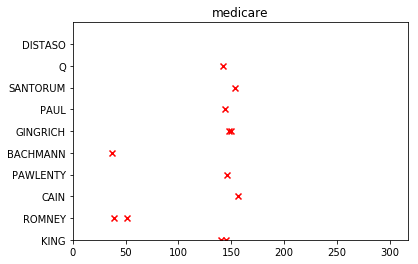

In [14]:
word = 'medicare'
idx = vec.vocabulary_[word]
time,speaker = cascades[idx].nonzero()
plt.scatter(time,speaker,color='r',marker='x')
plt.xlim(0,T)
plt.ylim(0,len(speakers))
plt.yticks(range(len(speakers)),speakers)
plt.title(word);

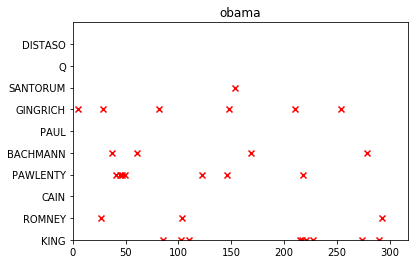

In [13]:
word = 'obama'
idx = vec.vocabulary_[word]
time,speaker = cascades[idx].nonzero()
plt.scatter(time,speaker,color='r',marker='x')
plt.xlim(0,T)
plt.ylim(0,len(speakers))
plt.yticks(range(len(speakers)),speakers)
plt.title(word);

(try to plot the cascade for another word)

# Modeling

Now that we have a set of cascades, we can use a Hawkes Process to try to estimate influence between the speakers.

First, we'll build a model. There are a few arguments:

- $K$, the number of event sources (speakers);
- whether to allow self-connections (in this case, no);
- $B$, the number of bases of the time-decay kernel (arbitrarily set to $B=5$).

In [15]:
hp = pyhawkes.models.DiscreteTimeStandardHawkesModel(K, allow_self_connections=False, B=5, dt_max=10)

## Time-decay kernel details

In `pyhawkes`, the kernel function is modeled as a sum over $B$ simple basis models,
\begin{equation}
\kappa_{i\to j}(\Delta t) = \sum_{b=1}^B g_b^{(i \to j)} \phi_b(\Delta t).
\end{equation}
- As the number of basis models increases, the decay kernel can be increasingly complex. 
- Each basis model is an impulse function, which is required to sum to 1.
- The weights over basis models, $g_b$, are dyad-specific.

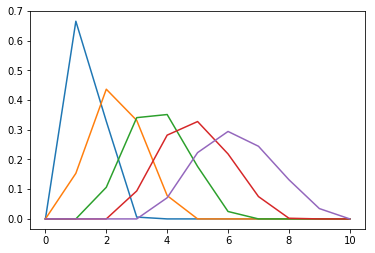

In [16]:
plt.plot(hp.basis.basis);

## Adding training data

We have already generated the cascades; now we add them as training data to the model.

In [16]:
for cascade in cascades:
    hp.add_data(cascade)

## Training

Training is performed by gradient descent. Each speaker's events can be handled separately, enabling parallelization. 

In [17]:
# Unfortunately `pyhawkes` doesn't give an easy way to suppress its output, so I have to do an ugly hack.
from ipykernel.iostream import OutStream

# to recreate stdout in the notebook
session = sys.stdout.session
pub_thread = sys.stdout.pub_thread
stream_name = sys.stdout.name

In [18]:
# catch stdout
sys.stdout = open('hp-output.txt', 'w')

# train the model
hp.fit_with_bfgs_logspace()

# return stdout to the notebook
sys.stdout = OutStream(session, pub_thread, stream_name)

### Results

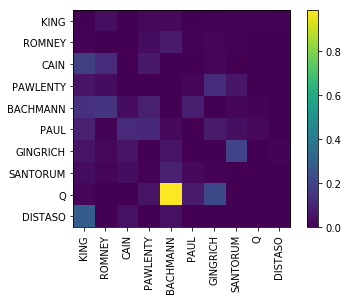

In [19]:
plt.imshow(hp.W)
plt.yticks(np.arange(len(speakers)),speakers);
plt.xticks(np.arange(len(speakers)),speakers,rotation=90)
plt.colorbar();

The audience questioners are strongly predictive of the speech of candidate Michelle Bachman, possibly reflecting a back-and-forth. Let's see if we can find it.

In [20]:
from IPython.display import HTML as html_print

In [21]:
def highlight_hits(text, wordlist, tokenizer):
    tokens = tokenizer(text)
    #print(tokens)
    new_tokens = [f'<b>{token}</b>' if token.lower() in wordlist else token for token in tokens]
    #print(new_tokens)
    return ' '.join(new_tokens)

In [22]:
def get_ab_pairs(data : pd.DataFrame,
                 speaker1 : str, 
                 speaker2 : str, 
                 max_gap : int = 3,
                 wordlist : list = [],
                 tokenizer = None):
    outputs = []
    for line, (speaker, text) in data.loc[data['speaker']==speaker1].iterrows():
        responses = data.loc[line:line+max_gap]
        s2_lines = responses.loc[responses['speaker']==speaker2]
        if len(s2_lines) > 0:
            if tokenizer is not None:
                html = highlight_hits(text, wordlist, tokenizer)
            #print(text)
            output = f'<UL><LI>{speaker1}({line}): {html}'
            hit_words = [word for word in list(set(wordlist).intersection(
                set([word.lower() for word in tokenizer(text)])))]
            #print(hit_words)
            
            for line2, (_, text2) in s2_lines.iterrows():
                if tokenizer is not None:
                    html = highlight_hits(text2, hit_words, tokenizer)
                output+=(f'<LI>{speaker2}({line2}): {html}')
            output+='</UL>'
            outputs.append(output)
            
    return outputs

In [23]:
tokenizer = vec.build_tokenizer()
wordlist = list(vec.vocabulary_.keys())

Printing nearby turns

In [24]:
# see the notebook for this function
pairs = get_ab_pairs(df,'Q','BACHMANN',wordlist=wordlist,tokenizer=tokenizer)
print(len(pairs))

2


In [25]:
html_print(pairs[0])

In [26]:
html_print(pairs[1])

Let's try some other dyads

In [27]:
pairs = get_ab_pairs(df,'Q','ROMNEY',wordlist=wordlist,tokenizer=tokenizer)
print(len(pairs))

0


In [28]:
pairs = get_ab_pairs(df,'Q','GINGRICH',wordlist=wordlist,tokenizer=tokenizer)
print(len(pairs))

0


In [29]:
pairs = get_ab_pairs(df,'Q','SANTORUM',wordlist=wordlist,tokenizer=tokenizer)
print(len(pairs))

1


In [30]:
html_print(pairs[0])

Other candidates either didn't get a chance to directly answer audience questions, or chose not to reuse terms from the question.

## Candidate interactions 

Now let's look at the interactions between the candidates themselves.

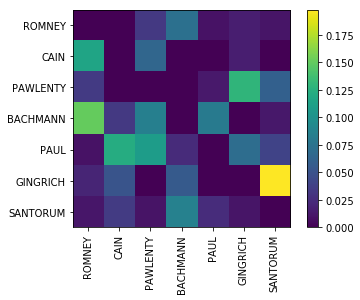

In [31]:
plt.imshow(hp.W[1:-2,1:-2])
plt.yticks(np.arange(len(speakers)-3),speakers[1:-2]);
plt.xticks(np.arange(len(speakers)-3),speakers[1:-2],rotation=90)
plt.colorbar();

The largest parameter is from Gingrich to Santorum. Let's look at their interactions.

In [32]:
pairs = get_ab_pairs(df,'GINGRICH','SANTORUM',wordlist=wordlist,tokenizer=tokenizer)
print(len(pairs))

3


In [33]:
html_print(pairs[0])

Here the connection is spurious: Gingrich mentions the need for winning seats in the Senate, and then Santorum talks about what he accomplished in the Senate.

In [34]:
html_print(pairs[1])

In [35]:
html_print(pairs[2])

In this case, Gingrich mentions the need for a constitutional amendment, and then Santorum follows up by making a similar argument.

# Hypothesis testing

- Are these parameters a meaningful indicator of discursive influence? 
- To answer this, let's compare the parameters with their **standard errors**
- In regression, it is easy to compute standard errors in closed form.
- In the Hawkes Process, it is not easy; there are solutions that work in the limit $T \to \infty$, but not for short samples.

[Reinhart 2017](https://arxiv.org/pdf/1708.02647.pdf) proposes a **parametric bootstrap**:

- Estimate parameters $\hat{\Theta}$ from the real data.
- Repeat:
    - Generate new data $\tilde{X}^{(i)} \sim f(\hat{\Theta})$
    - Estimate parameters $\tilde{\Theta}^{(i)}$ from $\tilde{X}^{(i)}$
- Compute the desired standard errors or confidence interval from $\{\tilde{\Theta}^{(i)}\}_{i=1}^N$

In [38]:
# save the current model, since the following lines are destructive
datadir = os.path.join('..','data')
hawkesfile = os.path.join(datadir,'hawkes.pkl')
with open(hawkesfile,'wb') as fout:
    pickle.dump(hp,fout)
    
with open(hawkesfile,'rb') as fin:
    hp_copy = pickle.load(fin)


In [39]:
# make a new stochastic model, from which we can sample
hp_gen = pyhawkes.models.DiscreteTimeNetworkHawkesModelGammaMixture(K=len(speakers),dt=1,B=5)

# initialize to trained hp
hp_gen.initialize_with_standard_model(hp)

# generate a bunch of cascades
cascades_samp = [hp_gen.generate(T=T)[0] for _ in range(len(cascades))]

# re-estimate from these cascades
hp_to_fit = pyhawkes.models.DiscreteTimeStandardHawkesModel(K=len(speakers),dt=1,B=5,
                                                            allow_self_connections=False)
for cascade in cascades_samp:
    hp_to_fit.add_data(cascade)
hp_to_fit.fit_with_bfgs_logspace()

# do this many times

In [40]:
run_it_yourself = False
bootstrap_file = os.path.join(datadir,'bootstrap-params.npy')

In [41]:
N_samp = 50
if run_it_yourself:
    params = []
    for _ in tqdm(range(N_samp)):
        cascades_samp = [hp_gen.generate(T=T)[0] for _ in range(len(cascades))]
        hp_to_fit = pyhawkes.models.DiscreteTimeStandardHawkesModel(K=len(speakers),dt=1,B=5,
                                                                    allow_self_connections=False)
        for cascade in cascades_samp:
            hp_to_fit.add_data(cascade)
        old_stdout = sys.stdout
        sys.stdout = open('stdout.txt', 'w')
        hp_to_fit.fit_with_bfgs_logspace()
        sys.stdout = old_stdout
        params.append(hp_to_fit.W)
    bootstrap_params = np.stack(params)
    np.savetxt(bootstrap_file,np.stack(params).reshape(N_samp*len(speakers),len(speakers)))
else:
    bootstrap_params = np.loadtxt(bootstrap_file).reshape(N_samp, len(speakers), len(speakers))

## Interpreting the bootstrap samples

The bootstrap samples give a sense of the possible variation for each parameter, which is due to the limited size of the training data. 

Let's visualize the set of excitation parameters from a single source, GINGRICH:

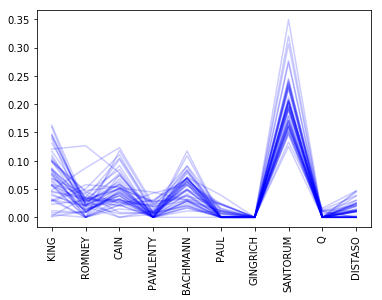

In [42]:
plt.plot(bootstrap_params[:,speakers.index('GINGRICH'),].T,color='b',alpha=0.2)
plt.xticks(range(len(speakers)),speakers,rotation=90);

This suggests that we can be confident about the excitation from Gingrich to Santorum, but less so about Gingrich's excitation on other participants.

Here's the same figure for excitation from the "Questioner" role:

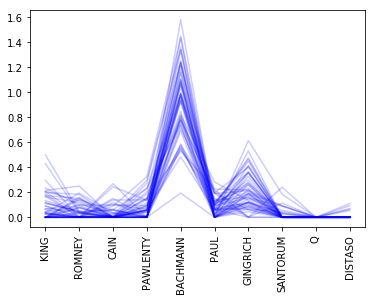

In [43]:
plt.plot(bootstrap_params[:,speakers.index('Q'),].T,color='b',alpha=0.2)
plt.xticks(range(len(speakers)),speakers,rotation=90);

We find strong evidence of excitation on Bachmann, but weaker evidence for most other recipients.

## Summarizing the bootstrap sample

Let's view the sample mean and the $z$-scores (mean divided by standard error)

In [44]:
z_scores = bootstrap_params.mean(0) / (1e-10 + bootstrap_params.std(0))

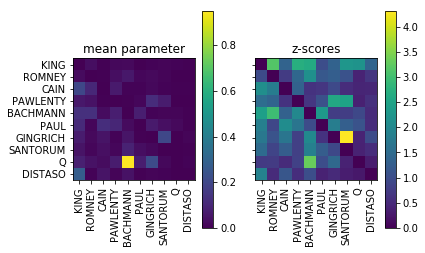

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)

im_mean = ax1.imshow((bootstrap_params.mean(0)))
fig.colorbar(im_mean, ax=ax1)
ax1.set_title('mean parameter');

im_z = ax2.imshow(z_scores)
fig.colorbar(im_z, ax=ax2)
ax2.set_title('z-scores');

ax1.set_yticks(range(len(speakers)))
ax1.set_yticklabels(speakers);
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(len(speakers)));
    ax.set_xticklabels(speakers,rotation=90);

- Although the parameter $(Q \to \text{Bachmann})$ has the largest magnitude, it does not have the highest $z$-score, because of large standard errors across samples.
- The (Gingrich $\to$ Santorum) dyad has the highest z-score, indicating the greatest confidence that its high value is not due to variance in the training sample.

How big of a $z$-score do we need to conclude that one individual consistently leads another?

- We have $p < \alpha$ when $\Phi(-|z|) < \alpha$, with $\Phi$ indicating the cumulative distribution function (CDF) of the normal distribution.
- The threshold $z$ score can be computed from the Percent Point Function (PPF), which is the inverse of the CDF.
- A one-tailed test is appropriate here, since Hawkes process parameters are non-negative.

In [46]:
from scipy.stats import norm

-norm.ppf(.05)

1.6448536269514729

- However, we are evaluating many parameters, not just one: in this case, $10 \times 9 = 90$
- At $p = .05$, we would accept $4.5$ Type I errors.
- The **Bonferroni correction** adjusts the threshold to $p / N$, where $N$ is the number of hypothesis tests (in this case, $N=90$).
- We can compute a corresponding threshold $z$-score for the parameter estimates.

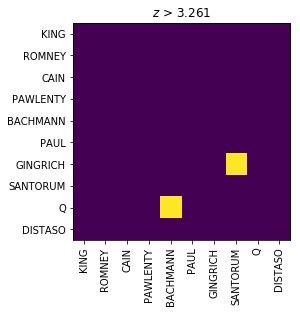

In [47]:
adjusted_p_val = .05 / (len(speakers) * (len(speakers)-1))
threshold = norm.ppf(1 - adjusted_p_val)
plt.imshow(z_scores > threshold)
plt.yticks(np.arange(len(speakers)),speakers);
plt.xticks(np.arange(len(speakers)),speakers,rotation=90)
plt.title(f'$z$ > {threshold:.3f}');

- The only dyads that pass the threshold are (Q $\to$ Bachmann) and (Gingrich $\to$ Santorum).
- The Bonferroni correction ensures that the expected number of Type I errors is $\alpha$, but this may be to conservative.
- The Benjamini-Hochberg **False Discovery Rate** (FDR) controls the probability of making a single Type I error, and generally results in a rejection threshold that is less conservative than $\alpha / N$.

- You may feel that because Romney responded to King so many times, we should downweight the number of times that Romney followed King's lexical choices.
- But the Hawkes Process model is not designed this way: it treats Romney's decision to respond as part of the data to explain, rather than conditioning on conversational structure (who spoke when) and modeling only the text.
- **Exercise**: how would you model lexical decisions conditioned on the conversational structure? When is each model appropriate?

# Extensions

- There are several other debate transcripts available in the data directory. Load in another one, and see whether the same patterns of influence hold.
- Explore better grouping/filtering of words to cascades, and see how this affects the results.
- In the last term's debate, Marco Rubio repeated a line [a number of times to the extent that even Chris Christie noticed](https://time.com/4210991/marco-rubio-gop-debate-new-hampshire/). Does this happen more often than we think? Explore this by modeling using HP by setting a self-excitation parameter and comparing it with the average excitation from others that a candidate gets.
- One possible theory of electoral debates is that candidates who are leading in the polls will try to stick to their original message, and not get drawn into arguments with other candidates. Test this hypothesis by comparing Hawkes Process parameters against [polling data](https://www.realclearpolitics.com/epolls/2012/president/us/republican_presidential_nomination-1452.html) (cf. [Prabhakaran et al 2013](https://cs.stanford.edu/~vinod/papers/2013_10_IJCNLP_Ranking_Participants_of_Interactions_Based_on_Their_Relative_Power.pdf))
